In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

# A Simple Example

In [3]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

In [20]:
scale(Variable(torch.Tensor([10])))

Variable containing:
 9.5266
[torch.FloatTensor of size 1]

In [38]:
posterior = pyro.infer.Importance(scale, num_samples=1000)

In [39]:
guess = Variable(torch.Tensor([8.5]))

marginal = pyro.infer.Marginal(posterior)

marginal(guess)

Variable containing:
 6.8008
[torch.FloatTensor of size 1]

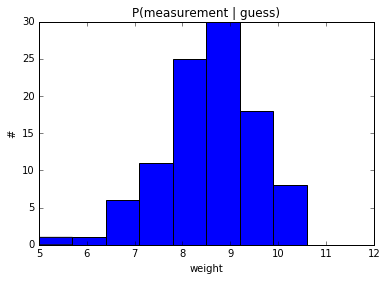

In [40]:
plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#")

# Conditioning Models on Data

In [41]:
conditioned_scale = pyro.condition(scale, data={"measurement": Variable(torch.Tensor([8.5]))})

In [42]:
# equivalent to pyro.condition(scale, data={"measurement": Variable(torch.ones(1))})
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # here we attach an observation measurement == 1
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.ones(1)),
                      obs=Variable(torch.Tensor([0.1])))

# equivalent to scale_obs:
def scale_obs(guess):
    z = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # here we attach an observation measurement == 1
    return pyro.observe("measurement", dist.normal, Variable(torch.ones(1)),
                       weight, Variable(torch.Tensor([0.1])))

{'weight': Variable containing:
 9.1052
[torch.FloatTensor of size 1]
}


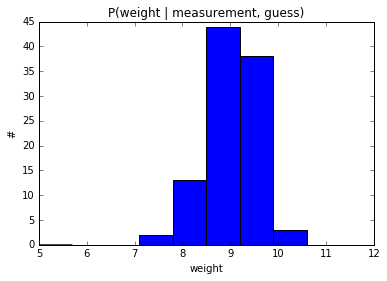

In [44]:
guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.Marginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100), sites=["weight"])

# The marginal distribution concentrates around the data
print(marginal(guess))
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")